# Vehicle Detection

### Steps Involved

1. Data Exploration
2. Feature Engineering - Color histograms, spatial bins, HOG features
3. Classification - Build classifier using algo such as DT, SVM or GBM, hyper-parameter tuning
4. Sliding window for search
5. HOG sub-sample
6. Heatmaps to eliminate false positives
7. Use techniques such as averaging across frames to smoothen tracking
8. Build pipeline
9. Test on Video stream

## Data Exploration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from skimage.feature import hog
from skimage import color, exposure
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.externals import joblib
from IPython.display import HTML
from moviepy.editor import VideoFileClip

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


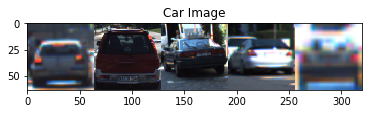

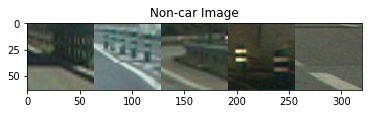

In [2]:
# images are divided up into vehicles and non-vehicles

base_dir = "/home/pyimagesearch/CarND-Vehicle-Detection/"

cars_string = base_dir + 'vehicles/*/' + '*.png'
non_cars_string = base_dir + 'non-vehicles/*/' + '*.png'

cars = glob.glob(cars_string)
notcars = glob.glob(non_cars_string)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_ind_list = range(car_ind, car_ind+5)
notcar_ind_list = range(notcar_ind, notcar_ind+5)

# Read in car / not-car images
car_images = np.hstack((mpimg.imread(cars[car_ind]) for car_ind in car_ind_list))
notcar_images = np.hstack((mpimg.imread(notcars[notcar_ind]) for notcar_ind in notcar_ind_list))


# Plot the examples
fig = plt.figure()
plt.imshow(car_images)
plt.title('Car Image')
fig = plt.figure()
plt.imshow(notcar_images)
plt.title('Non-car Image')
plt.show()

## Feature Engineering

In [3]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    
    hist_features = np.float32(np.array(hist_features).reshape(-1, 1))
    
    scaler = MinMaxScaler(copy = True, feature_range = (0, 1))
    hist_features = scaler.fit_transform(hist_features)
    hist_features = hist_features.reshape(-1,)
    
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def translate_image(img):
    
    rows,cols,channel = img.shape
    tx =  np.random.randint(-2, 2)
    ty =  np.random.randint(-2, 2)

    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return dst

def rotate_image(img, angle = 0):
    rows,cols,channel = img.shape
    theta = 10
    angle = np.random.randint(-theta, theta)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return dst

## Features Visualization

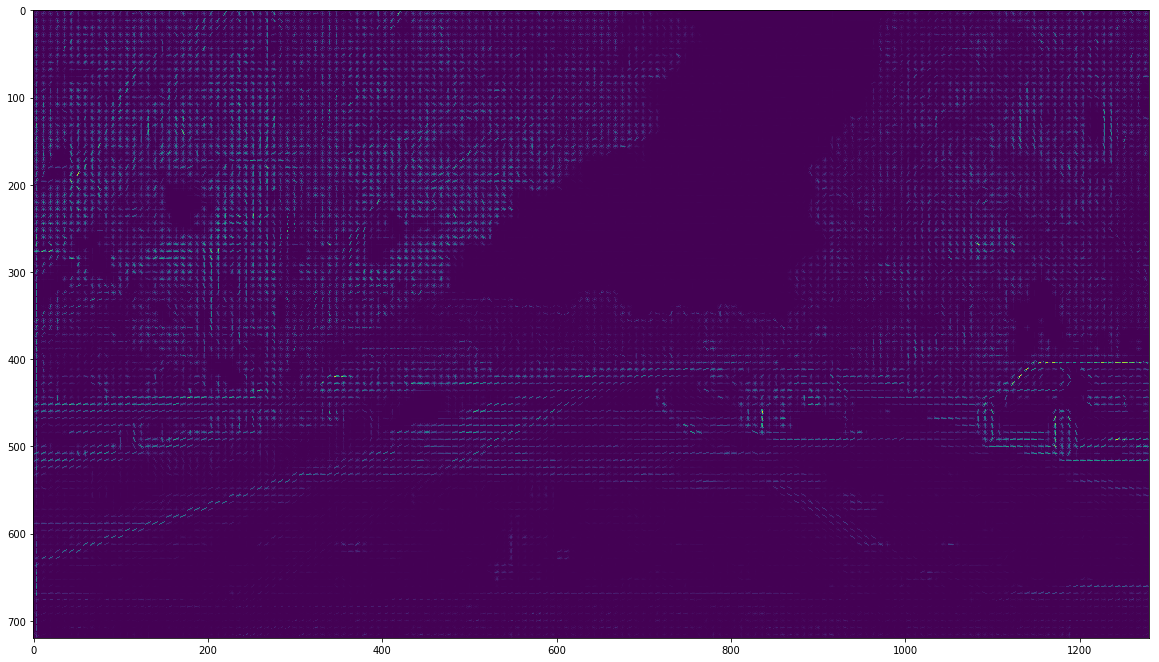

In [250]:
img = mpimg.imread('test_images/test5.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(img_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
fig = plt.figure()
plt.figure(figsize=(20,20))
plt.imshow(hog_image)
plt.show()

## HOG Features

In [4]:
debug = False

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='RGB', 
                     orient=9,
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel=0, 
                     nbins=32, 
                     bins_range=(0, 256), 
                     size=(32, 32),
                     need_hog_features = True,
                     need_spatial_features = True,
                     need_color_features = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        original = mpimg.imread(file)
        
        if (debug == True):
            print("original R channel =" + str(original[:,:,0]))
            print("original G channel =" + str(original[:,:,0]))
            print("original B channel =" + str(original[:,:,0]))
        
        augmented_images = [original]
        
        # Augment Data
        if (np.random.randint(10) == 1):
            rotated = rotate_image(original)
            augmented_images.append(rotated)
        elif (np.random.randint(50) == 1):
            translated = translate_image(original)
            augmented_images.append(translated)
        elif (np.random.randint(10) == 1):
            flipped = cv2.flip(original, 1)
            augmented_images.append(flipped)
            
        for image in augmented_images:
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)

            # HOG Features
            if need_hog_features == True:
                # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

                    if (debug == True):
                        print("hog_features mean = " + 
                              str(np.mean(hog_features)))
                        print("hog_features max = " + 
                              str(np.max(hog_features)))
                        print("hog_features min = " + 
                              str(np.min(hog_features)))
                        
            # Spatial Features
            if need_spatial_features == True:
                spatial_features = bin_spatial(image, size)
                if (debug == True):
                    print("spatial features mean = " + 
                          str(np.mean(spatial_features)))
                    print("spatial features max = " + 
                          str(np.max(spatial_features)))
                    print("spatial features min = " + 
                          str(np.min(spatial_features)))

            # Color histogram Features
            if need_color_features == True:
                color_features = color_hist(image, nbins, bins_range)
                if (debug == True):
                    print("color_features mean = " + 
                          str(np.mean(color_features)))
                    print("color_features max = " + 
                          str(np.max(color_features)))
                    print("color_features min = " + 
                          str(np.min(color_features)))

            # Append the new feature vector to the features list
            features.append(np.concatenate((spatial_features, color_features, hog_features)).ravel())       
            
    # Return list of feature vectors
    return features

In [5]:
# Extract features for single image

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(img, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


## Classification

In [6]:
debug = False
### Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
nbins=16
bins_range=(0, 256)
size=(16, 16)

t=time.time()

car_features = extract_features(cars,
                                cspace=colorspace, 
                                orient=orient,
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                nbins=nbins, 
                                bins_range=bins_range, 
                                size=size,
                                need_hog_features=True,
                                need_spatial_features=True,
                                need_color_features=True)

np.random.shuffle(car_features)

if (debug == True):
    print("car_features min = " + str(np.min(car_features)))
    print("car_features max = " + str(np.max(car_features)))
    print("car_features mean = " + str(np.mean(car_features)))

notcar_features = extract_features(notcars,
                                   cspace=colorspace, 
                                   orient=orient,
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   nbins=nbins,
                                   bins_range=bins_range, 
                                   size=size,
                                   need_hog_features=True,
                                   need_spatial_features=True,
                                   need_color_features=True)

np.random.shuffle(notcar_features)
                              
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

200.13 Seconds to extract HOG features...


## Model Training

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = np.nan_to_num(X)
X.shape

(21460, 11400)

In [14]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X = np.nan_to_num(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, 
                                                    random_state=rand_state)

print("Number of features = " + str(X_train.shape))

k_best = SelectKBest(f_classif, k=7000)

X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

print("X_train shape =" + str(X_train.shape))
print("X_test shape =" + str(X_test.shape))

print("X_train min = " + str(np.min(X_train)))
print("X_train max = " + str(np.max(X_train)))
print("X_train mean = " + str(np.mean(X_train)))
    
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#param_grid = {'C': [1e2, 1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

#param_grid = {'C': [1e2, 1e3, 5e3],
#              'gamma': [0.0001, 0.0005, 0.001],}
              
#clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=6)


#clf1 = SVC(kernel='rbf', class_weight='balanced', C=1e3, gamma=1e-4, probability=True)

clf_linear = LinearSVC()

# Check the training time for the SVC
t=time.time()
print("Starting training...")
#clf1.fit(X_train, y_train)
clf_linear.fit(X_train, y_train)
print("Done")
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC

Number of features = (17104, 11400)
X_train shape =(17104, 7000)
X_test shape =(4277, 7000)
X_train min = -1.70898063446
X_train max = 79.8519624212
X_train mean = -0.000167198023431
Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7000
Starting training...
Done
23.32 Seconds to train SVC...


In [16]:
clf = clf_linear

In [15]:
#print('Test Accuracy of SVC = ', round(clf1.score(X_test, y_test), 4))
print('Test Accuracy of SVC = ', round(clf_linear.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20

#print('My SVC predicts: ', clf1.predict(X_test[0:n_predict]))
print('My SVC predicts: ', clf_linear.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)

Test Accuracy of SVC =  0.9822
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.
  1.  1.]
For these 20 labels:  [ 0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.
  1.  1.]
0.01509 Seconds to predict 20 labels with SVC


# Ensembling

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

clf_gb = GradientBoostingClassifier(n_estimators=70, 
                                  learning_rate = 0.1,
                                  max_features = 'sqrt', 
                                  subsample = 0.7,
                                  random_state = 10)
clf_gb.fit(X_train, y_train)


clf_rf = RandomForestClassifier(n_estimators=30, 
                                  max_features = 'sqrt', 
                                  random_state = 10)
clf_rf.fit(X_train, y_train)

from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('svc', clf_linear),('gbm', clf_gb), ('rf', clf_rf)], 
                        voting='soft', 
                        weights=[7, 5, 4])
eclf.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of ensemble = ', round(eclf.score(X_test, y_test), 4))

n_predict = 20

print('My ensemble predicts: ', eclf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

In [13]:
save1 = eclf
save2 = clf1
clf = eclf

In [25]:
clf = clf_linear

In [12]:
joblib.dump(clf, 'model_eclf.pkl')
joblib.dump(clf1, 'model_kernel_svc.pkl')

['model_kernel_svc.pkl']

In [16]:
clf = joblib.load('model_hog_all.pkl')

## Sliding Window Search

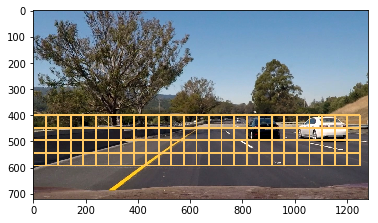

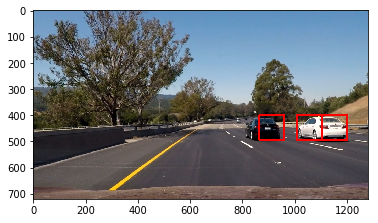

In [18]:
debug = False

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if (bbox[0][1]-bbox[0][0] != 0 and bbox[1][1]-bbox[1][0] != 0):
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Sliding window
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    X_my_test = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], 
                                  window[0][0]:window[1][0]], 
                                  (64, 64))
        #plt.imshow(test_img)
        #plt.show()
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                                   color_space=color_space, 
                                   orient=orient,
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   hist_bins=16, 
                                   spatial_size=(16,16),
                                   hog_feat=True,
                                   spatial_feat=True,
                                   hist_feat=True)
        #5) Scale extracted features to be fed to classifier
        
        if (debug == True):
            print("features min = "+str(np.min(features)))
            print("features max = "+str(np.max(features)))
            print("features mean = "+str(np.mean(features)))
        
        test_features = np.float32(np.array(features).reshape(1, -1))
        
        scaled_test_features = X_scaler.transform(test_features)
        
        if (debug == True):
            print("test_features = " + str(test_features) + " shape = " + str(test_features.shape))

        best_test_features = k_best.transform(scaled_test_features)

        if (debug == True):
            print("best_test_features min = " + str(np.min(best_test_features)))
            print("best_test_features max = " + str(np.max(best_test_features)))
            print("best_test_features mean = " + str(np.mean(best_test_features)))

        #6) Predict using your classifier
        predicted = clf.predict(best_test_features)
        
        if (debug == True):
            print("prediction = " + str(predicted))
        #7) If positive (prediction == 1) then save the window
        if predicted == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

cars_file = '/home/pyimagesearch/CarND-Vehicle-Detection/' + 'test_images/' + 'test6.jpg'

test_image = mpimg.imread(cars_file)
draw_image = np.copy(test_image)

windows = slide_window(test_image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[400, 600],
                       xy_window=(96, 96), 
                       xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_image, 
                        windows, 
                        color=(255, 200, 100), 
                        thick=6)
plt.imshow(window_img)
plt.show()

# Parameters for HOG, spatial and color histogram features

color_space = 'YCrCb'
orient = 18  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

x_start_stop = [None, None]
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

if (debug == True):
    print("test_image R = " + str(test_image[:,:,0]))
    print("test_image G = " + str(test_image[:,:,1]))
    print("test_image B = " + str(test_image[:,:,2]))

test_image = test_image.astype(np.float32)/255

if (debug == True):
    print("After scaling test_image R = " + str(test_image[:,:,0]))
    print("After scaling test_image G = " + str(test_image[:,:,1]))
    print("After scaling test_image B = " + str(test_image[:,:,2]))

hot_windows = search_windows(test_image, windows, clf, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)

plt.imshow(window_img)
plt.show()

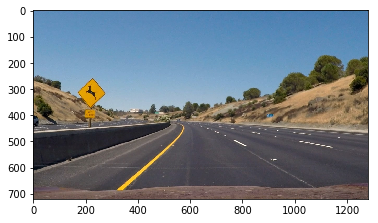

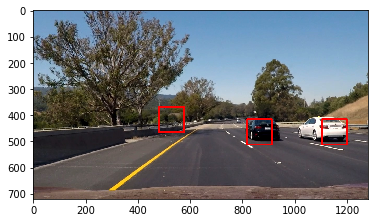

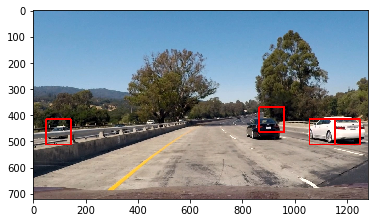

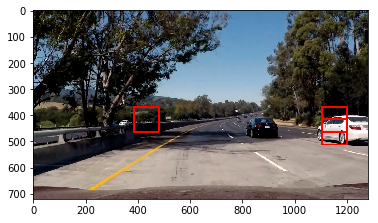

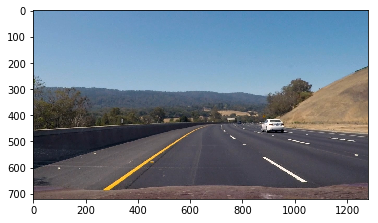

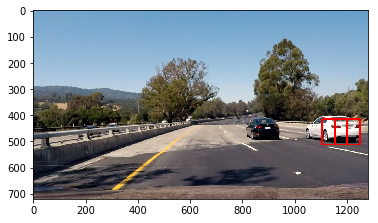

In [19]:
# detecting vehicle and adding boxes.
for img_file in glob.glob('test_images/test*.jpg'):
    image = mpimg.imread(img_file)
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[320, 600], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    hot_windows = []
  
    hot_windows += (search_windows(image, windows, clf, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat))                    
    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)

    plt.imshow(window_img)
    plt.show()

## Experimentation with sliding window size and overlap percentage

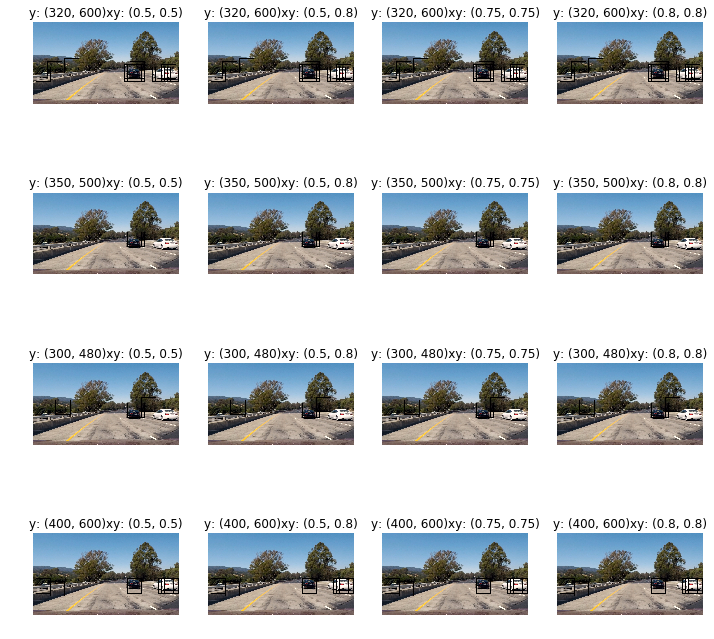

In [242]:
def experiment_sliding_window_overlap(img_file, y_start_stop, xy_overlap, i, gs):
    image = mpimg.imread(img_file)
    image = image.astype(np.float32)/255
    
    draw_image = np.copy(image)
    
    windows = slide_window(image, 
                           x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, 
                           xy_window=(128, 128), 
                           xy_overlap=(0.8, 0.8))

    hot_windows = []

    hot_windows += (search_windows(image, windows, clf, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat))                    
    window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)
    
    config = "y: " + str(y_start_stop) + "xy: " + str(xy_overlap)
    
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.set_title(config)
    plt.imshow(window_img)

# Grids to search
y_start_stops = [(320, 600), (350, 500), (300, 480), (400, 600)]

# Percentage Overlap of windows
xy_overlaps = [(0.5, 0.5), (0.5, 0.8), (0.75, 0.75), (0.8, 0.8)]

gs = gridspec.GridSpec(4, 4)
figure = plt.figure(figsize=(12,12))

count = 0
img_file = 'test_images/test1.jpg'

# Visualization of the bounding boxes
for y_start_stop in y_start_stops:
    for xy_overlap in xy_overlaps:
        experiment_sliding_window_overlap(img_file, y_start_stop, xy_overlap, count, gs)
        count += 1
plt.show()

## HOG Sub-sampling

In [36]:
20 // 3
pix_per_cell
X_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [140]:
debug = False

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def find_cars(img, ystart, ystop, scale_value, k_best, clf, scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
     
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    rectangles = []
  
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale_value != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale_value), 
                                                       np.int(imshape[0]/scale_value)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell

    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 3 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features1 = hog_features.reshape(-1, 1)
            
            if (debug == True):
                print("hog_features1 shape = " + str(hog_features1.shape))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = subimg.astype(np.float32)/255
            
           
            if (debug == True):
                print("subimg shape = " + str(subimg.shape))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            spatial_features1 = spatial_features.reshape(-1, 1)
            
            if (debug == True):
                print("spatial_features1 max = " + str(np.max(spatial_features1)))
                print("spatial_features1 shape = " + str(spatial_features1.shape))
           
            hist_features = color_hist(subimg, nbins=hist_bins)
            hist_features1 = hist_features.reshape(-1, 1)
            
            if (debug == True):
                print("hist_features1 max = " + str(np.max(hist_features1)))
                print("hist_features1 shape = " + str(hist_features1.shape))

             
            test_features = np.concatenate((spatial_features1,
                                         hist_features1, 
                                         hog_features1)).ravel()
                       
            test_features = np.nan_to_num(test_features)
                      
            if (debug == True):
                print("test_features shape = " + str(test_features.shape))
            
            # Select best features
            test_features = test_features.reshape(1, -1)
            scaled_test_features = scaler.transform(test_features)
            test_features = k_best.transform(scaled_test_features)
            
            test_prediction = clf.predict(test_features)
            if (debug == True):
                print("test_prediction = " + str(test_prediction))

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale_value)
                ytop_draw = np.int(ytop*scale_value)
                win_draw = np.int(window*scale_value)
                rectangles.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
    return rectangles

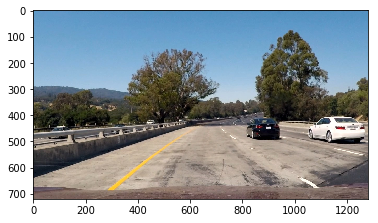

rectangles = [((28, 428), (104, 504)), ((57, 428), (133, 504)), ((86, 428), (162, 504)), ((259, 428), (335, 504)), ((806, 400), (882, 476)), ((835, 400), (911, 476)), ((864, 400), (940, 476)), ((864, 428), (940, 504)), ((979, 400), (1055, 476)), ((1065, 428), (1141, 504)), ((1123, 428), (1199, 504)), ((1152, 400), (1228, 476)), ((1152, 457), (1228, 533))]


In [232]:
param_list = [(400, 600, 1.2), (400, 464, 1.0), (416, 480, 1.0), 
              (400, 496, 1.5), (432, 528, 1.5), (400, 528, 2.0)]

rectangles = []

img = mpimg.imread('test_images/test1.jpg')
plt.imshow(img)
plt.show()

for car_tuple in param_list:
    boxes = find_cars(img, car_tuple[0], car_tuple[1], car_tuple[2], 
                      k_best, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rectangles.append(boxes)
    
rectangles = [item for sublist in rectangles for item in sublist]

print("rectangles = " + str(rectangles))

## Heat Maps

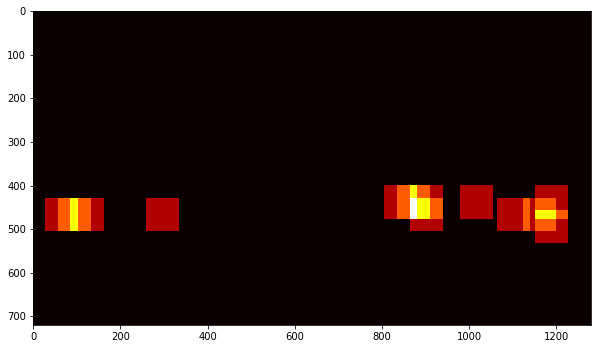

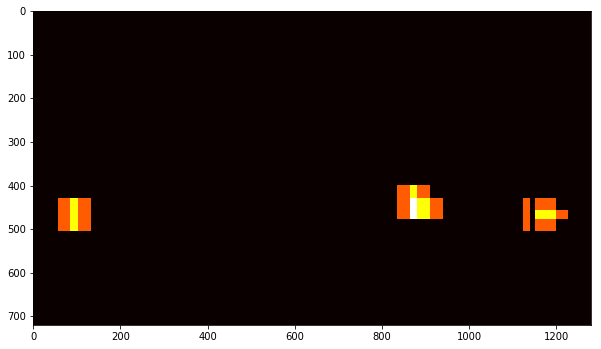

4 cars found


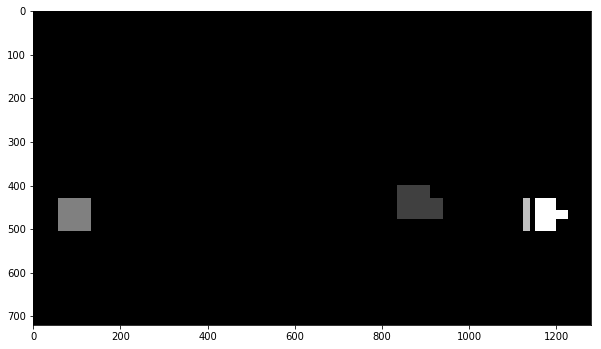

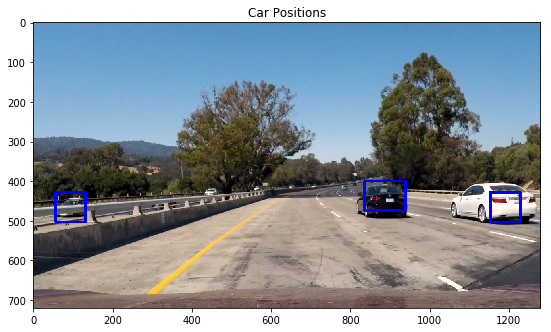

In [233]:
# Read in image similar to one shown above 
from scipy.ndimage import label

image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[int(box[0][1]):int(box[1][1]), int(box[0][0]):int(box[1][0])] += 3

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if (bbox[1][0] - bbox[0][0] >= 20):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

box_list = rectangles
# Add heat to each box in box list
heat = add_heat(heat,box_list)

plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')
plt.show()

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')
plt.show()

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.show()

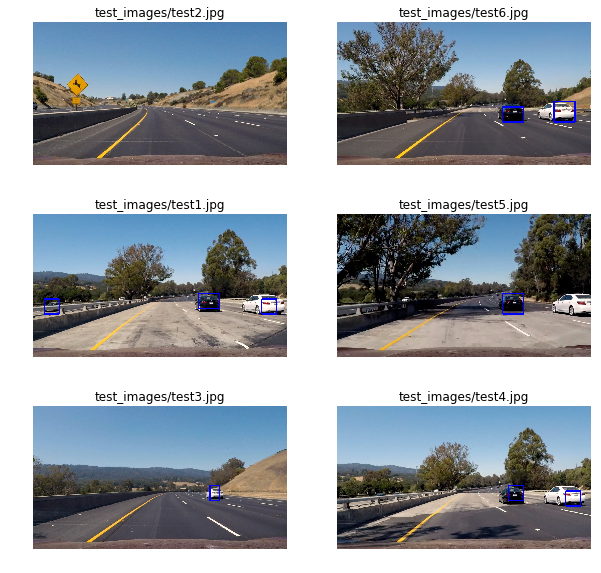

In [228]:
import matplotlib.gridspec as gridspec

param_list = [(400, 600, 1.2), (400, 470, 1.0), (420, 480, 1.0), 
                  (400, 500, 1.5), (430, 530, 1.5), (400, 530, 2.0),
                  (470, 660, 3.0)]

plt.gcf().clear()

gs = gridspec.GridSpec(3, 2)
figure = plt.figure(figsize=(10,10))

test_images = glob.glob('test_images/test*.jpg')

for i, img_file in enumerate(test_images):
    rectangles = []
    image = mpimg.imread(img_file)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for car_tuple in param_list:
        boxes = find_cars(image, car_tuple[0], car_tuple[1], car_tuple[2], 
                          k_best, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if (len(boxes) != 0):
            rectangles.append(boxes)
    rectangles = [item for sublist in rectangles for item in sublist]
    heat = add_heat(heat,rectangles)
    heat = apply_threshold(heat, 3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.set_title(img_file)
    plt.imshow(draw_img)     
plt.show()

## Pipeline

In [143]:
class Cars:
    def __init__(self):
        # List of boxes over last k frames
        self.box_list = []
        # Number of recent frames to be tracked
        self.recent_frame_count = 25
        # Total Number of frame count
        self.frame_count = 0
        # Track number of cars detected over last k frames
        self.prev_car_count_list = []
        # Previous and current car count list
        self.prev_car_count = 0
        self.curr_car_count = 0
        
    def add_cars(self, boxes):
        
        # Increment frame crount
        self.frame_count += 1
        self.box_list.append(boxes)
        self.prev_car_count_list.append(boxes)
        
    def update_car_count(self, car_count):
        self.prev_car_count = self.curr_car_count
        self.curr_car_count = car_count
        self.prev_car_count_list.append(car_count)
    
    def get_box_list(self):
        box_list_stack = list(self.box_list)       
        box_list_return = []
        
        for i in range(self.recent_frame_count):
            box_list_return.append(box_list_stack.pop())
                    
        return box_list_return

In [161]:
def process_frame(img):

    rectangles = []
    
    # Search grids with different scaling factors to search
    param_list = [(400, 600, 1.2), (400, 470, 1.0), (420, 480, 1.0), 
                  (400, 500, 1.5), (430, 530, 1.5), (400, 530, 2.0),
                  (470, 660, 3.0)]
    
    # Find the boxes and append to the list of rectangles
    for car_tuple in param_list:
        boxes = find_cars(img, car_tuple[0], car_tuple[1], car_tuple[2], 
                          k_best, clf, X_scaler, orient, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins)
        rectangles.append(boxes)
    
    rectangles = [item for sublist in rectangles for item in sublist]
    
    cars.add_cars(rectangles)
    
    # Create a heat map and used to filter out false positives
    if (cars.frame_count > 30 and cars.frame_count % 50 != 0):
        rectangles = cars.get_box_list()
        rectangles = [item for sublist in rectangles for item in sublist]
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heat, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 23)
    labels = label(heatmap_img)
    cars.update_car_count(labels[1])
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
    return draw_img

In [162]:
cars = Cars()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 24%|██▍       | 303/1261 [06:13<20:35,  1.29s/it]


 48%|████▊     | 605/1261 [12:25<13:06,  1.20s/it]


 72%|███████▏  | 907/1261 [19:16<06:59,  1.18s/it]


 96%|█████████▌| 1205/1261 [25:21<01:07,  1.21s/it]


100%|█████████▉| 1260/1261 [26:27<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 40min 51s, sys: 18.7 s, total: 41min 10s
Wall time: 26min 29s
